<a href="https://colab.research.google.com/github/RodrigoOBC/Notebooks_RedesNeurais/blob/main/pneumonia_class_with_alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import re
import glob
import os
import numpy as np
import pandas as pd
import random as rn
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.utils import to_categorical
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
path = '/kaggle/input/chest-xray-pneumonia/chest_xray/'


# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'


# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


# make path using / instead of \\ ... this may be redudant step
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]


# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])


# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

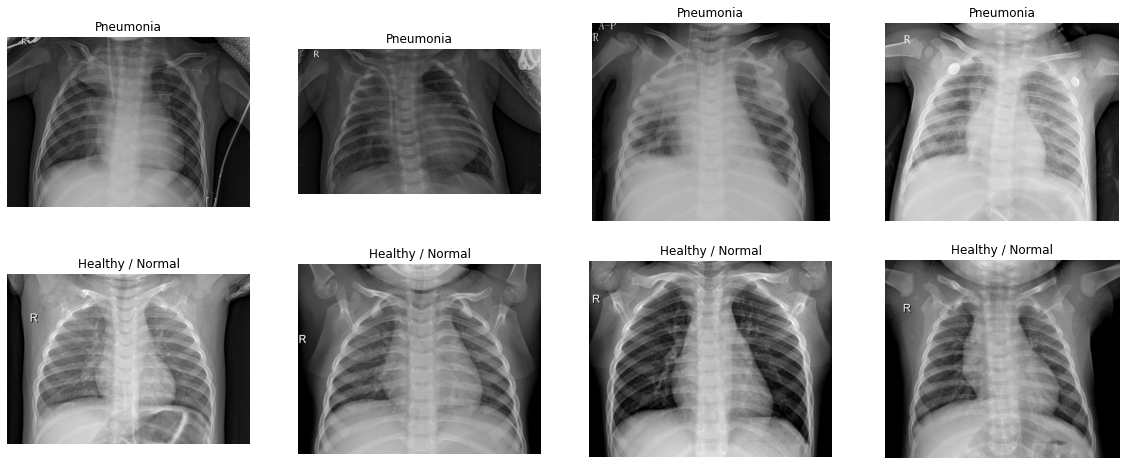

In [ ]:
plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')
    
for i,img_path in enumerate(train_df[train_df['label'] == 0][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Healthy / Normal')

In [ ]:
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (224,224,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [ ]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)



In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
AlexNet = models.Sequential()
AlexNet.add(layers.Conv2D(96, (5,5), activation = 'relu', input_shape=(224, 224, 1)))
AlexNet.add(layers.Conv2D(96, 11, strides=4, padding='same'))
AlexNet.add(layers.Lambda(tf.nn.local_response_normalization))
AlexNet.add(layers.Activation('relu'))
AlexNet.add(layers.MaxPooling2D(3, strides=2))
AlexNet.add(layers.Conv2D(256, 5, strides=4, padding='same'))
AlexNet.add(layers.Lambda(tf.nn.local_response_normalization))
AlexNet.add(layers.Activation('relu'))
AlexNet.add(layers.MaxPooling2D(3, strides=2))
AlexNet.add(layers.Conv2D(384, 3, strides=4, padding='same'))
AlexNet.add(layers.Activation('relu'))
AlexNet.add(layers.Conv2D(384, 3, strides=4, padding='same'))
AlexNet.add(layers.Activation('relu'))
AlexNet.add(layers.Conv2D(256, 3, strides=4, padding='same'))
AlexNet.add(layers.Activation('relu'))
AlexNet.add(layers.Flatten())
AlexNet.add(layers.Dense(4096, activation='relu'))
AlexNet.add(layers.Dropout(0.5))
AlexNet.add(layers.Dense(4096, activation='relu'))
AlexNet.add(layers.Dropout(0.5))
AlexNet.add(layers.Dense(1000, activation='relu'))
AlexNet.add(layers.Dropout(0.5))
AlexNet.add(layers.Dense(128, activation='relu'))
AlexNet.add(layers.Dropout(0.5))
AlexNet.add(layers.Dense(64, activation='relu'))
AlexNet.add(layers.Dropout(0.5))
AlexNet.add(layers.Dense(2, activation='softmax'))
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 96)      2496      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 96)        1115232   
_________________________________________________________________
lambda (Lambda)              (None, 55, 55, 96)        0         
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         614656    
_________________________________________________________________
lambda_1 (Lambda)            (None, 7, 7, 256)         0

In [ ]:
AlexNet.compile(optimizer='Adam', loss='categorical_crossentropy', 
              metrics = ['accuracy'])

callback = EarlyStopping(monitor='loss', patience=25)

In [ ]:
history = AlexNet.fit(datagen.flow(X_train,y_train, batch_size=32), validation_data=(X_test, y_test), epochs = 100, verbose = 1, callbacks=[callback], class_weight={0:6.0, 1:0.5})

Epoch 1/100
163/163 [==============================] - 44s 219ms/step - loss: 1.0689 - accuracy: 0.3317 - val_loss: 1.0357 - val_accuracy: 0.3750
Epoch 2/100
163/163 [==============================] - 35s 212ms/step - loss: 0.8201 - accuracy: 0.3922 - val_loss: 0.7947 - val_accuracy: 0.6346
Epoch 3/100
163/163 [==============================] - 35s 214ms/step - loss: 0.8336 - accuracy: 0.5251 - val_loss: 1.0644 - val_accuracy: 0.3750
Epoch 4/100
163/163 [==============================] - 35s 216ms/step - loss: 1.0072 - accuracy: 0.4411 - val_loss: 0.8787 - val_accuracy: 0.6010
Epoch 5/100
163/163 [==============================] - 35s 216ms/step - loss: 0.7038 - accuracy: 0.5199 - val_loss: 0.7025 - val_accuracy: 0.6506
Epoch 6/100
163/163 [==============================] - 35s 216ms/step - loss: 0.7208 - accuracy: 0.5848 - val_loss: 0.8108 - val_accuracy: 0.6619
Epoch 7/100
163/163 [==============================] - 35s 214ms/step - loss: 0.7305 - accuracy: 0.5608 - val_loss: 0.7111 -

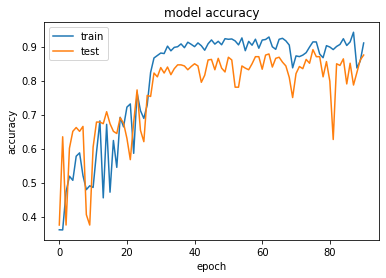

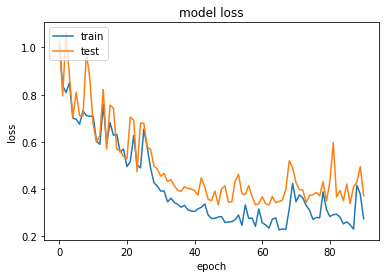

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
pred = AlexNet.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

Acurácia: 0.8750
Sensitividade: 0.7393
Especificidade: 0.9564


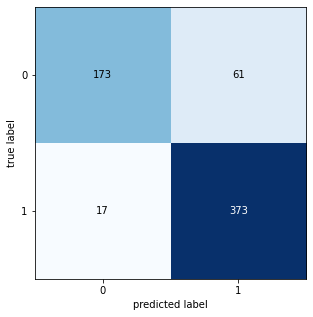

In [ ]:

cm = confusion_matrix(y_true, pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("Acurácia: {:.4f}".format(acc))
print("Sensitividade: {:.4f}".format(sensitivity))
print("Especificidade: {:.4f}".format(specificity))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show();